In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
import yfinance as yf
import tensorflow as tf
from pandas_datareader.yahoo.daily import YahooDailyReader
from stockstats import StockDataFrame
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler


# Define the list of stock tickers and the date range
stock_tickers = ['OXY']#, 'GOOGL', 'MSFT']  # Replace with your list of stock tickers
start_date = '1954-01-01'  # Replace with your desired start date
end_date = '2023-10-09'  # Replace with your desired end date
# end_date = datetime.today()


def create_time_steps(length):
    return list(range(-length, 0))

def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(18, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 0]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
        label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append([target[i+target_size]])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

def multinew_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []   

    # start_index = start_index + history_size
    start_index = -history_size
    if end_index is None:
        end_index = len(dataset) 

    for i in range(start_index, end_index-target_size):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

    return np.array(data)

def prediction_plot(history, prediction):
    plt.figure(figsize=(18, 6))
    num_in = create_time_steps(len(history))
    num_out = len(prediction[0])

    plt.plot(num_in, np.array(history), label='History')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction)[0], 'ro',
                 label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

In [2]:
# # Loop over each stock ticker
# # for ticker in stock_tickers:
# # Download stock price data using yfinance

In [3]:
ticker = stock_tickers[0]

df = yf.download(ticker, start=start_date, end=end_date, auto_adjust=False)
df = StockDataFrame.retype(df)
TRAIN_SPLIT = int(df.shape[0] * 0.8)
df.head()

[*********************100%%**********************]  1 of 1 completed


,open,high,low,close,adj close,volume
Date,,,,,,
1981-12-31,11.347040,11.496737,11.197343,11.496737,1.719850,431705
1982-01-04,11.496737,11.556616,11.376979,11.496737,1.719850,329624
1982-01-05,11.376979,11.436858,11.317101,11.317101,1.692977,383274
1982-01-06,11.317101,11.376979,11.257222,11.376979,1.701934,281819
1982-01-07,11.317101,11.376979,11.257222,11.376979,1.701934,168674


tema: 0.999
atr: 0.789
supertrend: 0.994
boll: 0.997
vwma: 0.998
kama: 0.999


In [4]:
all_features = ['close','rsi','log-ret','rsv','rsi','stochrsi','wt1']#,'smma','roc','mad','trix','tema','vr','wr','cci','atr','suppertrend','dma','kdjk','cr','boll','macd','ppo','vwma','chop','mfi','eribull','ker','kama','aroon','ao','bop','coppock','ichimoku','cti','ftr','rvgi','inertia','kst','pgo','psl','pvo','qqe']
all_df = df[all_features]

all_df.corr()

,close,rsi,log-ret,rsv,rsi,stochrsi,wt1
close,1.000000,0.057997,0.011459,0.047496,0.057997,0.022315,0.061329
rsi,0.057997,1.000000,0.311295,0.734393,1.000000,0.520870,0.880127
log-ret,0.011459,0.311295,1.000000,0.449029,0.311295,0.422471,0.068112
rsv,0.047496,0.734393,0.449029,1.000000,0.734393,0.848372,0.473763
rsi,0.057997,1.000000,0.311295,0.734393,1.000000,0.520870,0.880127
stochrsi,0.022315,0.520870,0.422471,0.848372,0.520870,1.000000,0.230391
wt1,0.061329,0.880127,0.068112,0.473763,0.880127,0.230391,1.000000


In [5]:
features_considered = ['close']#,'atr']
features = df[features_considered]
features.index = df.index
features.head()

,close
Date,
1981-12-31,11.496737
1982-01-04,11.496737
1982-01-05,11.317101
1982-01-06,11.376979
1982-01-07,11.376979


array([<Axes: xlabel='Date'>], dtype=object)

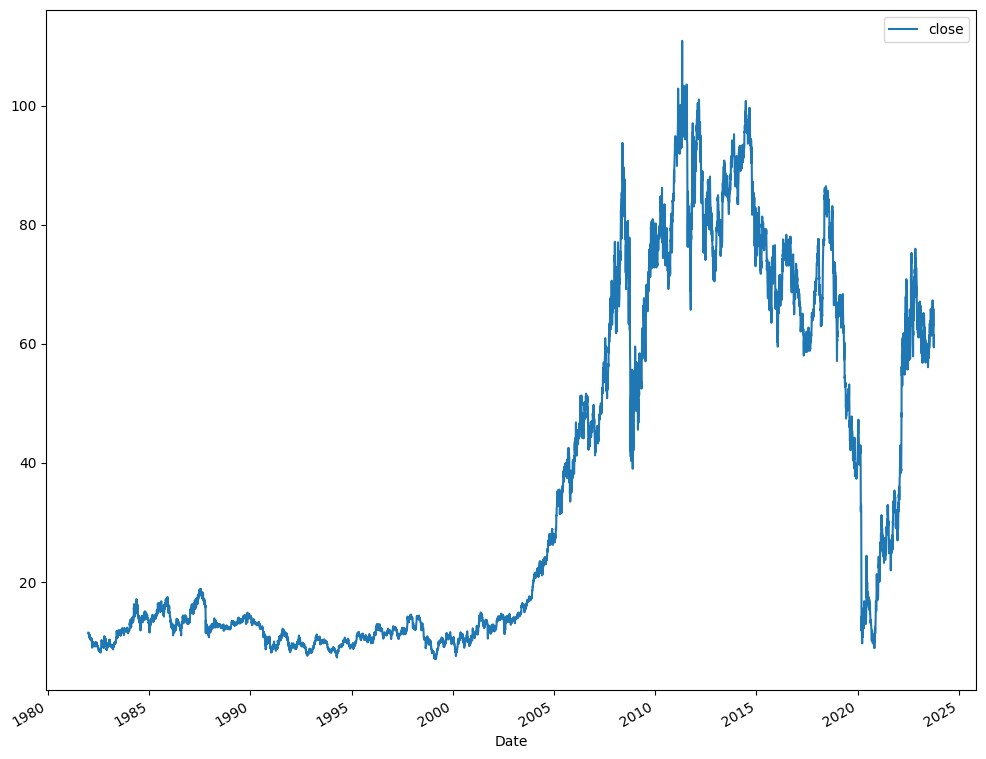

In [6]:
features.plot(subplots=True,figsize=[12,10])

In [7]:
# Assuming your dataframe is called 'df' with columns 'column1', 'column2', 'column3'
# columns_to_normalize = ['close','high']

# # Create an instance of MinMaxScaler
# scaler = MinMaxScaler()

# # Fit the scaler on the selected columns
# scaler.fit(features[columns_to_normalize])

# # Transform the selected columns using the scaler
# features[columns_to_normalize] = scaler.transform(features[columns_to_normalize])

# dataset = features.values


dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std


pd.DataFrame(dataset, columns = features.columns, index = features.index).head()

,close
Date,
1981-12-31,-0.649533
1982-01-04,-0.649533
1982-01-05,-0.655697
1982-01-06,-0.653642
1982-01-07,-0.653642


In [8]:
past_history = 20
future_target = 5
STEP = 1

# Hyperparameters
BATCH_SIZE = 64
BUFFER_SIZE = 2000



x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 0], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP, True)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 0],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP, True)



# train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
# train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

# val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
# val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

print (x_train_multi.shape,
       y_train_multi.shape,
       'Single window of past history : {}'.format(x_train_multi[0].shape),
       'Target price to predict : {}'.format(y_train_multi[0].shape),
       sep='\n')

(8404, 20, 1)
(8404, 1)
Single window of past history : (20, 1)
Target price to predict : (1,)


In [9]:
# for x, y in val_data_multi.take(1):
#     multi_step_plot(x[0], y[0], np.array([0]))

In [10]:
# LSTM Parameters
EVALUATION_INTERVAL = 30 #len(x_train_multi)//batch_size//2 #15
VALIDATION_INTERVAL = 30 #len(x_val_multi)//batch_size//2
EPOCHS = 50
PATIENCE = 5

# Reproducibility
SEED = 42
tf.random.set_seed(SEED)

In [11]:
multi_step_model = tf.keras.models.Sequential()
# multi_step_model.add(tf.keras.layers.LSTM(128,
#                                           return_sequences=True,
#                                           recurrent_dropout=0.3,
#                                           input_shape=x_train_multi.shape[-2:]))
# multi_step_model.add(tf.keras.layers.Dropout(0.4))
# multi_step_model.add(Dense(64))

# multi_step_model.add(tf.keras.layers.LSTM(64))
# multi_step_model.add(tf.keras.layers.Dropout(0.4))
# multi_step_model.add(Dense(32))

# multi_step_model.add(Dense(1,activation='linear'))

multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          recurrent_dropout=0.3,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.Dropout(0.4))
multi_step_model.add(Dense(16))

multi_step_model.add(tf.keras.layers.LSTM(16))
multi_step_model.add(tf.keras.layers.Dropout(0.4))
multi_step_model.add(Dense(8))

multi_step_model.add(Dense(1,activation='linear'))



multi_step_model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.0005),loss='mae', metrics='accuracy')
print(multi_step_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 32)            4352      
                                                                 
 dropout (Dropout)           (None, 20, 32)            0         
                                                                 
 dense (Dense)               (None, 20, 16)            528       
                                                                 
 lstm_1 (LSTM)               (None, 16)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                

In [12]:
early_stopping = EarlyStopping(monitor='val_loss', patience = PATIENCE, restore_best_weights=True)
multi_step_history = multi_step_model.fit(x_train_multi,y_train_multi,
                                          epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=(x_val_multi,y_val_multi),
                                          validation_steps=VALIDATION_INTERVAL,
                                          callbacks=[early_stopping])

Epoch 1/50


2023-10-16 23:29:50.411278: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
external_state_policy: POLICY_IGNORE
autotune_options {
}
warm_start: false



30/30 [==============================] - ETA: 0s - loss: 0.7026 - accuracy: 0.0000e+00

2023-10-16 23:29:52.885073: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



30/30 [==============================] - 3s 34ms/step - loss: 0.7026 - accuracy: 0.0000e+00 - val_loss: 0.6934 - val_accuracy: 0.0000e+00
Epoch 2/50
30/30 [==============================] - 1s 19ms/step - loss: 0.2996 - accuracy: 0.0000e+00 - val_loss: 0.2307 - val_accuracy: 0.0000e+00
Epoch 3/50
30/30 [==============================] - 1s 19ms/step - loss: 0.2021 - accuracy: 0.0000e+00 - val_loss: 0.1123 - val_accuracy: 0.0000e+00
Epoch 4/50
30/30 [==============================] - 1s 20ms/step - loss: 0.1839 - accuracy: 0.0000e+00 - val_loss: 0.1097 - val_accuracy: 0.0000e+00
Epoch 5/50
30/30 [==============================] - 1s 21ms/step - loss: 0.1748 - accuracy: 0.0000e+00 - val_loss: 0.1154 - val_accuracy: 0.0000e+00
Epoch 6/50
30/30 [==============================] - 1s 20ms/step - loss: 0.1641 - accuracy: 0.0000e+00 - val_loss: 0.1251 - val_accuracy: 0.0000e+00
Epoch 7/50
30/30 [==============================] - 1s 19ms/step - loss: 0.1598 - accuracy: 0.0000e+00 - val_loss: 0.

In [13]:
# plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

<Axes: title={'center': 'Accuracy'}>

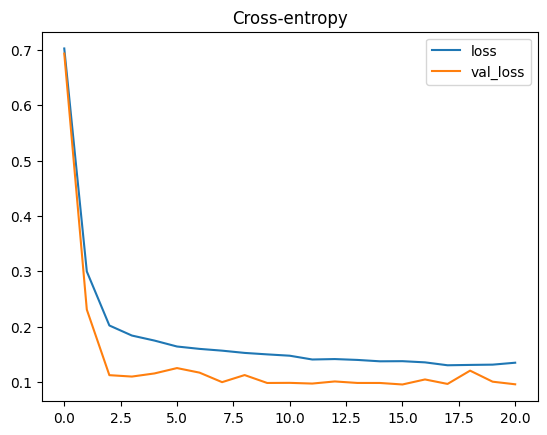

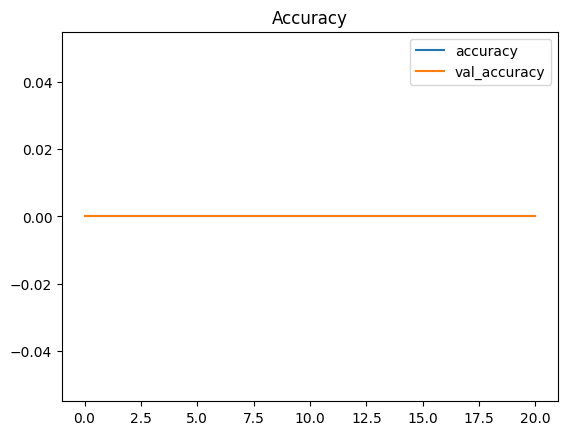

In [14]:
history_df = pd.DataFrame(multi_step_history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['accuracy', 'val_accuracy']].plot(title="Accuracy")

2023-10-16 23:30:05.321021: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are 
2023-10-16 23:30:05.341914: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



1/1 [==============================] - 0s 317ms/step


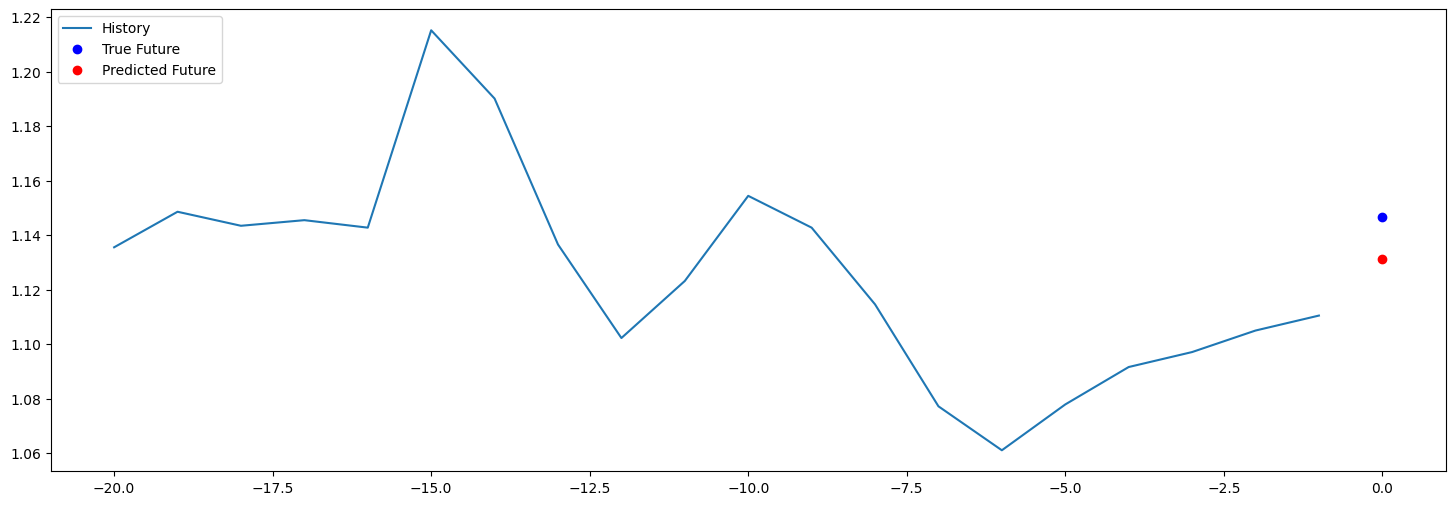

In [15]:
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 0],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP, True)

x_val_multi = x_val_multi[-20:]
y_val_multi = y_val_multi[-20:]

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))

val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

for x, y in val_data_multi.take(1):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])


In [16]:
x_new_multi = multinew_data(dataset, dataset[:, 0],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP, True)

x_new_multi = x_new_multi[-45:]



predictions_0 = multi_step_model.predict(x_new_multi[0:1])
predictions_1 = multi_step_model.predict(x_new_multi[-1:])#[0]


predictions_0, predictions_1

2023-10-16 23:30:05.805873: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



1/1 [==============================] - 0s 9ms/step


2023-10-16 23:30:06.122550: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



(array([[1.074345]], dtype=float32), array([[1.1952138]], dtype=float32))

In [17]:
%%capture command
predictions = []
for i in range(40):
    predictions.append(float(multi_step_model.predict(x_new_multi[i:i+1])))

2023-10-16 23:30:06.151828: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false

2023-10-16 23:30:06.173696: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false

2023-10-16 23:30:06.197390: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false

2023-10-16 23:30:06.220753: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_opt

In [18]:
x_new_multi[0][:,0].shape
# pd.DataFrame(predictions).transpose()
len(predictions)

40

In [19]:
x_new_multi = multinew_data(dataset, dataset[:, 0],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)
x_new_multi = x_new_multi[-40:]

In [20]:
x_new_multi[:,0,0].shape

(40,)

In [21]:
df_pred=pd.concat([pd.DataFrame([predictions]).transpose(), pd.DataFrame(x_new_multi[:,0,0])],axis=1)
# df_pred=pd.DataFrame([predictions]).transpose()
df_pred.columns = ['Predictions','True Value']
df_pred

,Predictions,True Value
0,1.074345,0.967042
1,1.082164,0.970130
2,1.090631,1.033608
3,1.098116,1.060029
4,1.102607,1.064146
5,1.106330,0.993462
6,1.111481,0.990374
7,1.117861,1.017481
8,1.124427,1.020226
9,1.130983,1.030520


<Axes: >

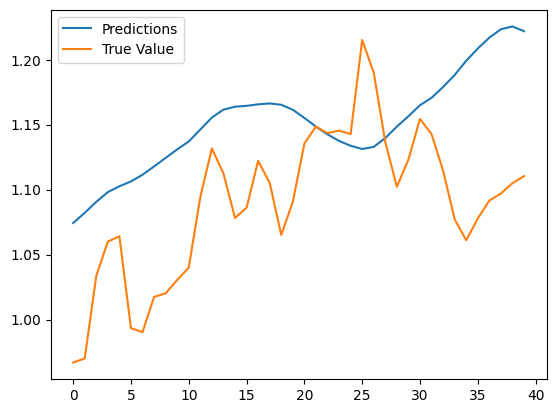

In [22]:
df_pred.plot()

In [23]:
# df_pred.apply(lambda row: abs(row[0] - row[1]), axis=1)
mae = df_pred.apply(lambda row: abs(row[0] - row[1]), axis=1).mean()

print("Mean Absolute Error (MAE):", mae)

Mean Absolute Error (MAE): 0.06952883939266659


/var/folders/ym/67x0srsx2ln9vy4qtlvtdv500000gn/T/ipykernel_8406/424334069.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mae = df_pred.apply(lambda row: abs(row[0] - row[1]), axis=1).mean()


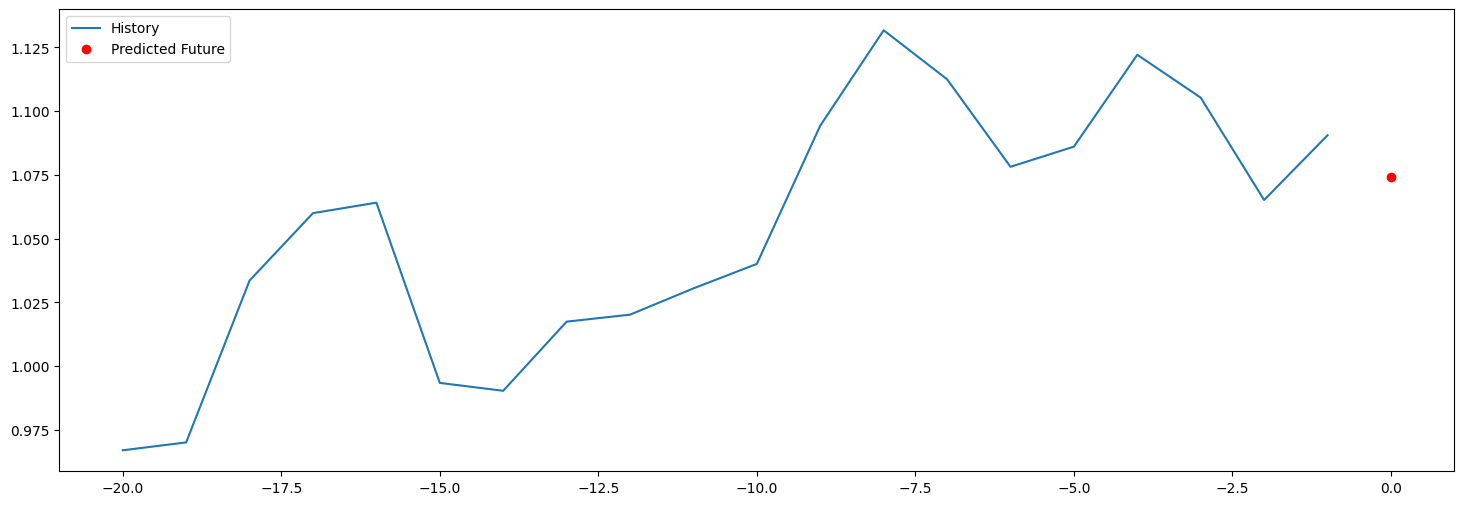

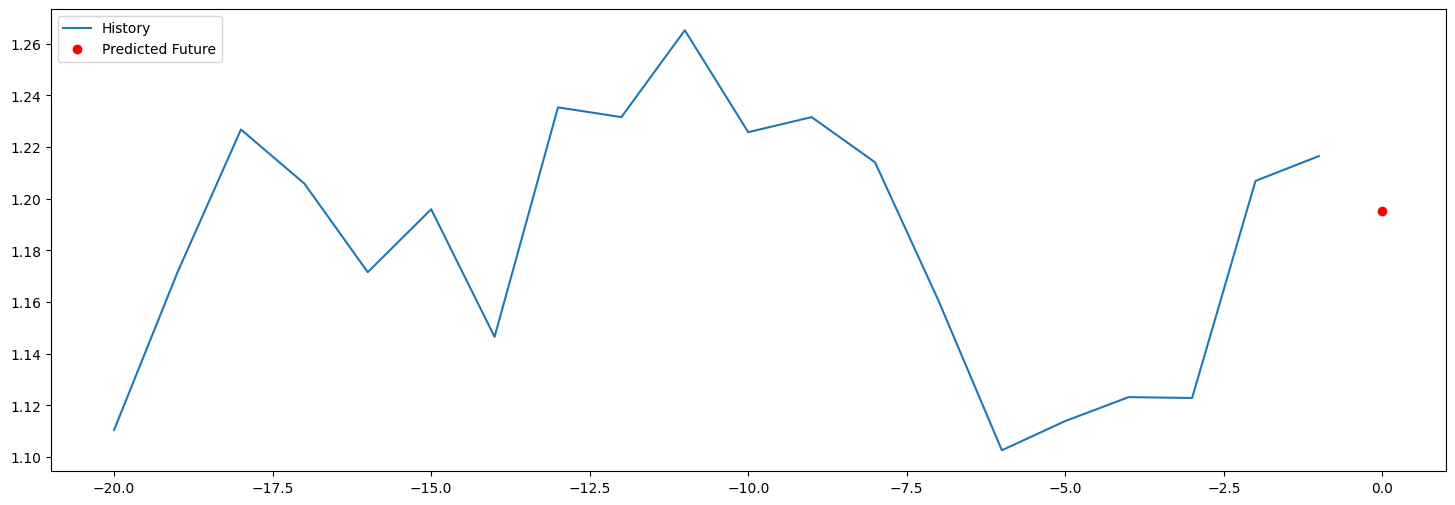

In [24]:
# New Predictions
prediction_plot(x_new_multi[0][:,0], predictions_0)
prediction_plot(x_new_multi[-1][:,0], predictions_1)

In [25]:
# multi_step_model.save(f"model/model_{ticker}.h5")

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
